In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

import sys
from tqdm import tqdm

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Загрузка данных

In [2]:
from tensorflow.keras.datasets.mnist import load_data

In [3]:
(X_train, y_train), (_, _) = load_data()

In [4]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

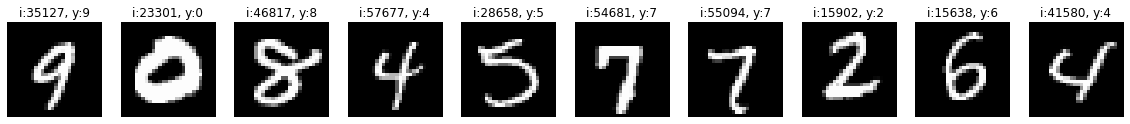

In [5]:
_, ax = plt.subplots(1,10, figsize=(20,5))
for i in range(10):
    num = np.random.randint(0, X_train.shape[0])
    ax[i].imshow(X_train[num], cmap='gray')
    ax[i].set_title("i:{}, y:{}".format(num, y_train[num]))
    ax[i].axis('off')
plt.show()

# GAN

In [7]:
SAMPLE_SIZE = 100
PIC_SIZE = 784

In [54]:
generator = Sequential()

generator.add(L.Dense(256, input_dim=SAMPLE_SIZE))
generator.add(L.LeakyReLU(0.2))

generator.add(L.Dense(512))
generator.add(L.LeakyReLU(0.2))

generator.add(L.Dense(1024))
generator.add(L.LeakyReLU(0.2))

generator.add(L.Dense(PIC_SIZE, activation='tanh'))

In [55]:
discriminator = Sequential()

discriminator.add(L.Dense(1024, input_dim=PIC_SIZE))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(512))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(256))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(1, activation='sigmoid'))

In [56]:
discriminator.trainable = False

ganInput = L.Input(shape=(SAMPLE_SIZE,))
x = generator(ganInput)
ganOutput = discriminator(x)

gan = tf.keras.models.Model(inputs=ganInput, outputs=ganOutput)

In [57]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [58]:
digits = []
Dloss = []
Gloss = []

In [59]:
X_train_proc = (X_train.astype(np.float32) - 127.5)/127.5
X_train_proc = X_train_proc.reshape(60000, 784)

In [60]:
EPOCHS = 1
BATCH_SIZE = 512

for e in range(EPOCHS):
    for _ in range(int(X_train_proc.shape[0]/BATCH_SIZE)):
        
        # train discriminator
        noise = np.random.normal(0, 1, size=(BATCH_SIZE*99, SAMPLE_SIZE))
        generated_images = generator.predict(noise)    
        X_train_disc = np.concatenate([X_train_proc[np.random.randint(0, X_train.shape[0], BATCH_SIZE)], 
                                       generated_images])
        y_train_disc = np.zeros(BATCH_SIZE*100)
        y_train_disc[:BATCH_SIZE] = 0.95
        
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X_train_disc, y_train_disc)
        Dloss.append(dloss)
            
        #train generator
        X_train_gan = np.random.normal(0, 1, size=(int(BATCH_SIZE/512), SAMPLE_SIZE))
        y_train_gan = np.ones(shape=int(BATCH_SIZE/512))

        discriminator.trainable = False    
        gloss = gan.train_on_batch(X_train_gan, y_train_gan)
        Gloss.append(gloss)
    
    print("Epoch {}, dloss {}, gloss {}".format(e, dloss, gloss))
    digits.append(generator.predict(np.random.normal(0,1,size=(3,SAMPLE_SIZE))))    

Epoch 0, dloss 9.413320541381836, gloss 0.00021756475325673819


In [18]:
for i in np.random.randint(0,10,2):
    data_ = np.random.normal(0, 1, size=(1,SAMPLE_SIZE))
    r1 = gan.predict(data_)
    r2 = discriminator.predict(X_train_proc[i].reshape(-1,784))
    print(r1, r2)

[[0.9999941]] [[0.51511514]]
[[0.99999404]] [[0.60482824]]


In [ ]:
plt.plot(Dloss)
plt.plot(Gloss)
plt.show()

In [ ]:
show_digits = digits[::10]
len(digits)

In [ ]:
_, ax = plt.subplots(len(show_digits),3, figsize=(20,20))
for i in range(len(show_digits)):
    for j, digit in enumerate(show_digits[i]):
        ax[i][j].imshow(digit.reshape(28,28))
plt.show()

In [ ]:
data_ = np.random.normal(0,1,size=SAMPLE_SIZE)
print(data_)
img_ = generator.predict(data_.reshape(1,-1))
print(img_[0][:28])
plt.imshow(img_.reshape(28,28))
plt.show()